In [ ]:
#install library

!pip install pyspark
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=823edd0b68263e71eefcf6ac60d0f71b2391a9fa3bb96a838a1374f7890fb076
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
#import library
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#buat spark session

spark = SparkSession.builder \
    .appName("Klastering di Spark") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()


In [ ]:
#load data
data_path = "data_customer.csv"
df = pd.read_csv(data_path)

#pre-processing konversi ke dalam bentuk numerik
df["Gender"] = df["Gender"].map({"laki-laki": 0, "perempuan": 1})
df["MaritalStatus"] = df["MaritalStatus"].map({"belum menikah": 0, "sudah menikah": 1})
df["HomeOwner"] = df["HomeOwner"].map({"tidak memiliki rumah sendiri": 0, "memiliki rumah sendiri": 1})
df["Occupation"] = df["Occupation"].map({
    "unskilled manual work": 0, "skilled manual work": 1, "clerical work": 2,
    "sales": 3, "management": 4, "professional": 5})
df["Education"] = df["Education"].map({
    "SMA": 0, "S1": 1, "S2": 2, "S3": 3, "Post-graduate": 4})
spark_df = spark.createDataFrame(df)
print("Data loaded and preprocessed successfully.")


Data loaded and preprocessed successfully.


In [ ]:
#model building
k = 5
assembler = VectorAssembler(inputCols=["IncomeRange", "Education", "Occupation"], outputCol="features")
train = assembler.transform(spark_df).select('CustomerName', 'features')
kmeans = KMeans(featuresCol=assembler.getOutputCol(), predictionCol="cluster", k=k, seed=0)
model = kmeans.fit(train)
print("Model trained successfully.")

Model trained successfully.


In [ ]:
#prediksi
prediction = model.transform(assembler.transform(spark_df))

prediction.groupBy("cluster").count().orderBy("cluster").show()
prediction.select('CustomerName', 'cluster').show(10)
print("Predictions made successfully.")

+-------+-----+
|cluster|count|
+-------+-----+
|      0| 2068|
|      1| 2009|
|      2| 1970|
|      3| 1964|
|      4| 1989|
+-------+-----+

+---------------+-------+
|   CustomerName|cluster|
+---------------+-------+
| Usman Setiawan|      3|
|Fitri Anggraini|      2|
|   Agus Susanto|      2|
|Taufik Haryanto|      0|
|  Indra Hidayat|      0|
| Rizki Mahendra|      1|
|    Vina Fauzan|      3|
|  Nina Setiawan|      4|
|  Indra Purnomo|      2|
|   Wati Susanto|      4|
+---------------+-------+
only showing top 10 rows

Predictions made successfully.


In [ ]:
# Apply the transformation to the original spark_df DataFrame to add the "features" column
prediction = model.transform(assembler.transform(spark_df))

#ganti nama kolom cluster jadi prediction
prediction = prediction.withColumnRenamed('cluster', 'prediction')

prediction.groupBy("prediction").count().orderBy("prediction").show()
prediction.select('CustomerName', 'prediction').show(10)
print("Predictions made successfully.")

evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
silhouette_score = evaluator.evaluate(prediction)
print(f'Silhouette Score: {silhouette_score}')


+----------+-----+
|prediction|count|
+----------+-----+
|         0| 2068|
|         1| 2009|
|         2| 1970|
|         3| 1964|
|         4| 1989|
+----------+-----+

+---------------+----------+
|   CustomerName|prediction|
+---------------+----------+
| Usman Setiawan|         3|
|Fitri Anggraini|         2|
|   Agus Susanto|         2|
|Taufik Haryanto|         0|
|  Indra Hidayat|         0|
| Rizki Mahendra|         1|
|    Vina Fauzan|         3|
|  Nina Setiawan|         4|
|  Indra Purnomo|         2|
|   Wati Susanto|         4|
+---------------+----------+
only showing top 10 rows

Predictions made successfully.
Silhouette Score: 0.7237541215009036


In [ ]:
cluster_number = 0  #penamaan cluster menggunakan urutan angka
num_records = 10    #jumlah data yang ditampilkan
prediction.filter(prediction.prediction == cluster_number).select('CustomerName', 'prediction').show(num_records) # Use 'prediction' instead of 'cluster'

+---------------+----------+
|   CustomerName|prediction|
+---------------+----------+
|Taufik Haryanto|         0|
|  Indra Hidayat|         0|
|   Joko Pratama|         0|
|  Putri Santoso|         0|
|     Agus Hakim|         0|
|  Joko Muliawan|         0|
|   Siti Susanto|         0|
|     Hadi Utomo|         0|
|   Agus Pratama|         0|
|   Nina Santoso|         0|
+---------------+----------+
only showing top 10 rows



In [ ]:
#deskripsi tiap cluster
def describe_cluster_data(prediction, cluster_number):
    # Use 'prediction' instead of 'cluster' to filter
    cluster_data = prediction.filter(prediction.prediction == cluster_number).toPandas()
    description = cluster_data.describe()
    print(f"Cluster {cluster_number} Description:\n", description)

for i in range(k):
    describe_cluster_data(prediction, i)

Cluster 0 Description:
                Age  MaritalStatus   IncomeRange       Gender  TotalChildren  \
count  2068.000000    2068.000000   2068.000000  2068.000000    2068.000000   
mean     43.338008       0.487427  33567.519342     0.518375       2.531431   
std      15.134436       0.499963   7777.234089     0.499783       1.718022   
min      18.000000       0.000000  20005.000000     0.000000       0.000000   
25%      30.000000       0.000000  26862.000000     0.000000       1.000000   
50%      43.000000       0.000000  33591.500000     1.000000       3.000000   
75%      56.250000       1.000000  40374.000000     1.000000       4.000000   
max      69.000000       1.000000  46912.000000     1.000000       5.000000   

       ChildrenAtHome    Education   Occupation    HomeOwner         Cars  \
count     2068.000000  2068.000000  2068.000000  2068.000000  2068.000000   
mean         1.284333     1.972921     2.500967     0.504836     1.494197   
std          1.414353     1.41737

Index(['CustomerName', 'Age', 'MaritalStatus', 'IncomeRange', 'Gender',
       'TotalChildren', 'ChildrenAtHome', 'Education', 'Occupation',
       'HomeOwner', 'Cars', 'features', 'prediction'],
      dtype='object')


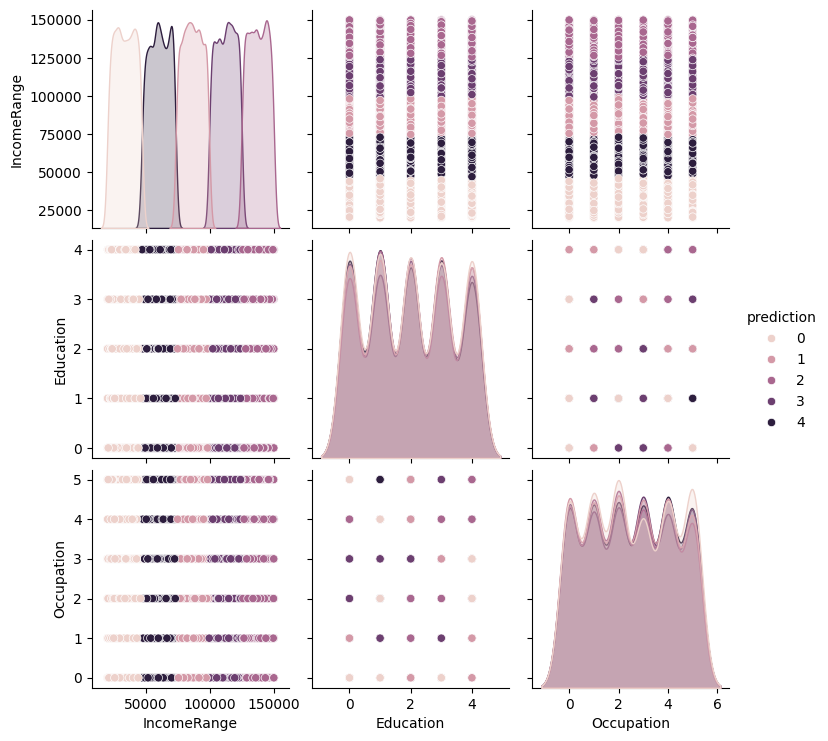

In [ ]:
#visualisasi data
def plot_clusters(prediction):
    prediction_pd = prediction.toPandas()

    # Print available columns to verify if 'IncomeRange' exists
    print(prediction_pd.columns)

    # Adjust column names in 'vars' if needed based on available columns
    sns.pairplot(prediction_pd, hue='prediction', vars=["IncomeRange", "Education", "Occupation"])  # Use 'prediction' instead of 'cluster'
    plt.show()

plot_clusters(prediction)